# Convolutions

In [1]:
import numpy as np
from numpy import linalg as lin
import pandas as pd
import os

import wave

from scipy import signal, misc
import scipy as spy

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
os.chdir('C:\\Users\\ericn\\Documents\\University\\2021\\Quantitative Project\\Numbers audio dataset\\recordings')
fileNames = os.listdir()
#listdir will list everything within the directory (aka folder).

## Opening a Wav file

In [3]:
#import one example for now
file1 = wave.open("0_jackson_1.wav", mode="r")
raw1 = file1.readframes(-1)
rawArray1 = np.frombuffer(raw1,"int16")   #this is a (1xn) array, I can use Reshape if I need it for convolve. <- Not so sure about this as rawArray1 works 

In [4]:
rawArray1

array([-311,  -91, -140, ...,  378,  357,  333], dtype=int16)

Text(0.5, 0, 'Time')

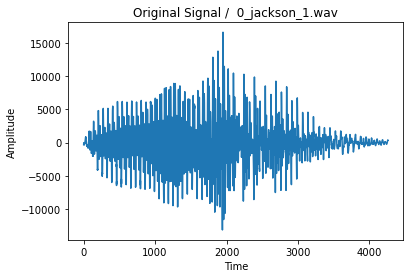

In [5]:
plt.plot(rawArray1)
#structure
plt.title("Original Signal /  0_jackson_1.wav")
plt.ylabel('Amplitude')
plt.xlabel('Time')
#lt.savefig("Original Signal")

#### Filtering signal: h

In [6]:
from scipy.fft import fft, ifft

In [7]:
y=fft(rawArray1)

C:\Users\ericn\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


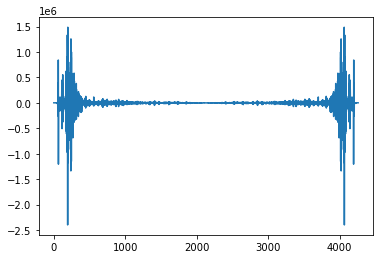

In [8]:
plt.plot(y)

In [9]:
filtered = ifft(y[:1000])

C:\Users\ericn\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


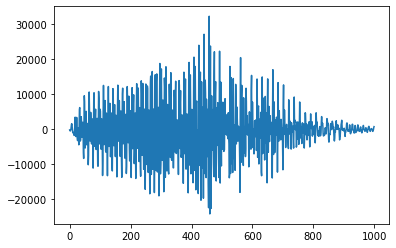

In [10]:
plt.plot(filtered)

In [11]:
def movingAverageFilter(arg):
    ratio = 1/arg
    window=np.array([])
    for i in range(arg):
        window = np.append(window, ratio)
    return window

print(movingAverageFilter(5))

[0.2 0.2 0.2 0.2 0.2]


Text(0.5, 0, 'Time [sec]')

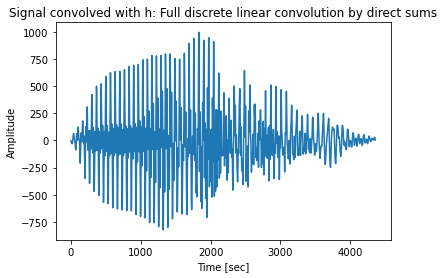

In [12]:
conv1=signal.convolve(rawArray1,movingAverageFilter(100), mode='full', method='direct')
plt.plot(conv1)
plt.title("Signal convolved with h: Full discrete linear convolution by direct sums")
plt.ylabel('Amplitude')
plt.xlabel('Time [sec]')

Text(0.5, 0, 'Time')

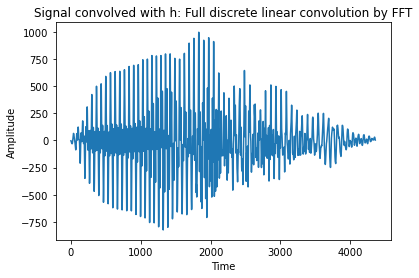

In [13]:
conv1 = signal.convolve(rawArray1,movingAverageFilter(100), mode='full', method='fft')
plt.plot(conv1)
plt.title("Signal convolved with h: Full discrete linear convolution by FFT")
plt.ylabel('Amplitude')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

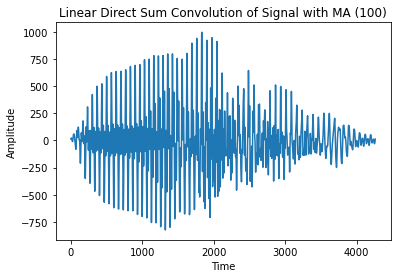

In [14]:
#convolve by direct sums
"""
Takes the inputs (x,h) where x is designed as the signal and h is the filter
It calculates the value for y(n) then in

"""

def convolve_LinearDirectSums(arg1, arg2): #(x, h)
    y = np.array([])
    add = 0
    for k in range(arg1.size):
        for i in range(arg2.size):
            add = add + arg2[i]*arg1[k-i]
        y = np.append(y, add)
        add = 0
    return y

data1 = convolve_LinearDirectSums(rawArray1,movingAverageFilter(100))
plt.plot(data1)
plt.title("Linear Direct Sum Convolution of Signal with MA (100)")
plt.ylabel('Amplitude')
plt.xlabel('Time')

In [15]:
#Array splitting:
"""
Goal -> Create a smaller subset of the signal to enable working without large computation requirments
Variables
L: how many paritions of the signal

reshapeArray is so the signal is in the form (nx1) for later matrix multplication

"""
def signalSplit(inputA, L, Vert = True):
    if(Vert):
        reshape = inputA.reshape((-1,1))
        paritition = np.array_split(reshape, L)
    else:
        paritition = np.array_split(inputA, L)
        
    return paritition[0]    #first partition

In [16]:
signal_part1 = signalSplit(rawArray1,1)
print("is it even? value: " + str(signal_part1.size))
#Ensuring that M is even
if (signal_part1.size % 2):
    signal_part1 = np.delete(signal_part1,[0])
print(signal_part1.size)

is it even? value: 4261
4260


In [17]:
def convlve_CircularLinA (arg1, arg2):       #(Signal, filter)
    #create the circulant matrix from the filter, Needs to be an (n x n) matrix
    signal_dim = arg1.reshape((-1,1))
    zeros = np.zeros((1,(signal_dim.size - arg2.size)))
    filter_padd = np.append(arg2,zeros)
    filter_circ = spy.linalg.circulant(filter_padd)
    #complete the circular convolution by Linear algebra
    conv_Signal = np.dot(filter_circ,signal_dim)
    #represe
    final = conv_Signal.reshape((1,-1)).flatten()
    plt.plot(final)
    plt.title("Circular convolution of Signal")
    plt.ylabel('Amplitude')
    plt.xlabel('Time')
    return final

array([30.76, 27.6 , 23.14, ..., 20.18, 29.94, 37.86])

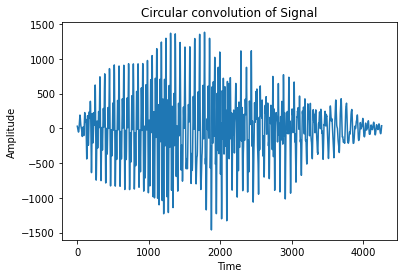

In [18]:
#moving average filter (averages 50 values)
convlve_CircularLinA(rawArray1,movingAverageFilter(50))

# Applied Dihedral convolution

The signal of length m:
$ \boldsymbol{X} = \big\{ \ x_{1},x_{2},x_{3},...,x_{m} \ \big\}$

The filter:
$ \boldsymbol{u} = \big\{  \alpha_{0}, \alpha_{1}, \alpha_{2}, \cdots  , \alpha_{n-1},\ \beta_{0}, \beta_{1},\beta_{2}, \ ... \ , \beta_{n-1} \big\} \qquad \alpha_{i} \ , \beta_{i} \  \in R $

Note: Length of $u$ is 2n

In [19]:
#Reverse circulant
"""
1. Take an input array (1 x n)
2. construct an (n x n) matrix where the elements move as a resevse circ
-----
"""

def reverseCirc(inputA):
    L = len(inputA)
    temp = inputA
    for i in range(1,L):
        a = inputA[i:]
        b = inputA[:i]
        temp = np.concatenate((temp.flatten(),a,b))
    new = temp.reshape((-L,L))
    return new
#this is really inefficent for memory storage

In [20]:
"""
1. Filter.size = Signal size = m : specifying that M should be even so the alphas and betas split evenly.
**The filter should be padded before use**

This function paritions the filter into alphas and beta per the definition of vector u.

It then uses scipy circluant and the defined reverse circulant functions to create matricies A & B.
Where A is the Circulant & B is the Reverse Circulant. 

Finally these are combined in block matrix form to represent the RG matrix of the Dihedral group(n): "block"
"""

def blockMatrix_Dn (filter_1):
    #creating arrays of Alpha and betas
    L = filter_1.size
    bound = int(L/2) #takes integer part 5.9 -> 5
    #print(bound)
    alpha_1 = filter_1[ :bound]
    beta_1 = filter_1[bound: ]
    
    # the Circulant and reverse circulant comes from the filter.
    A = spy.linalg.circulant(alpha_1)
    B = reverseCirc(beta_1)
    #print(A.shape)
    #print("---")
    #print(B.shape)
    #Creating a block matrix of A & B per dihedral RG matrix form
    block = np.block([[A,B],[B,A]])
    return block


In [21]:
# filter padding
filter_temp = movingAverageFilter(100)

zeros = np.zeros((1,(signal_part1.size - filter_temp.size)))
filter_padd = np.append(filter_temp,zeros)

dih_convolve1 = np.dot(blockMatrix_Dn(filter_padd), signal_part1)

Text(0.5, 0, 'Time')

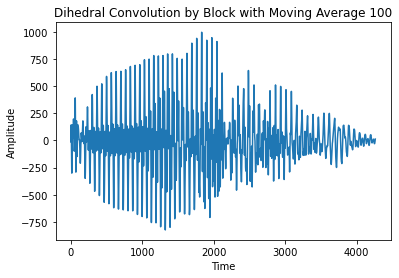

In [22]:
plt.plot(dih_convolve1)
plt.title("Dihedral Convolution by Block with Moving Average 100")
plt.ylabel('Amplitude')
plt.xlabel('Time')

#### More efficient form
Applying docomposed method $\tau = (A,B,B,A) \quad \tau *x = linear\  eq$
1. A -> Circulant of alpha's
2. B -> Reverse Circulant of beta's
3.   $x_{1}$ & $x_{2}$ -> signal split into two


$\begin{bmatrix}
Ax_{1} \ + \ Bx_{2} \\
Bx_{1} \ + \ Ax_{2}
\end{bmatrix}$

In [23]:
"""

"""

def dih_convolve2(filterArg, signalArg):
    #partion the signal
    if(filterArg.size == signalArg.size):
        L = filterArg.size 
        bound = int(L/2)    #takes integer part 5.9 -> 5
    else:
        print("the dimensions of the filter and signal don't match")
        return
    
    x1 = signalArg[:bound]
    x2 = signalArg[bound:]
    #if (x1.size == x2.size):
        #print("Correct size")
    #Creating A & B
    
    alpha_1 = filterArg[ :bound]
    beta_1 = filterArg[bound: ]
    
    # the Circulant and reverse circulant comes from the filter.
    A = spy.linalg.circulant(alpha_1)
    B = reverseCirc(beta_1)
    
    #compute ax, bx
    y1 = np.add(np.dot(A,x1.T), np.dot(B,x2.T))    #Form Ax1 + Bx2
    y2 = np.add(np.dot(B,x1.T), np.dot(A,x2.T))    #Form Bx1 + Ax2
    
    return np.append(y1,y2).transpose()    #final signal

Text(0.5, 0, 'Time')

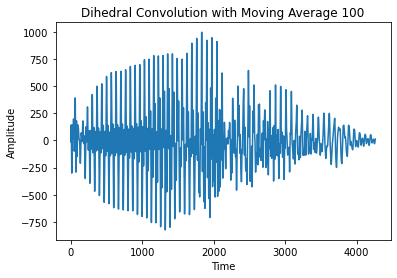

In [24]:
# filter padding
filter_temp = movingAverageFilter(100)

zeros = np.zeros((1,(signal_part1.size - filter_temp.size)))
filter_padd = np.append(filter_temp,zeros)

dih_data = dih_convolve2(filter_padd, signal_part1)
plt.plot(dih_data)
plt.title("Dihedral Convolution with Moving Average 100")
plt.ylabel('Amplitude')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

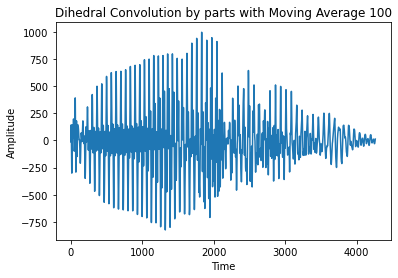

In [25]:
plt.plot(dih_data)
plt.title("Dihedral Convolution by parts with Moving Average 100")
plt.ylabel('Amplitude')
plt.xlabel('Time')

### Plot differences


In [70]:
#Importing the wav files
file1 = wave.open(fileNames[151], mode="r")
raw1 = file1.readframes(-1)
raw_temp = np.frombuffer(raw1,"int16")

In [71]:
L =raw_temp.shape[0]

if(L%2 == 1):
    raw_temp=raw_temp[1:]

In [75]:
fileNames[151]

'1_jackson_1.wav'

Text(0.5, 0, 'Time')

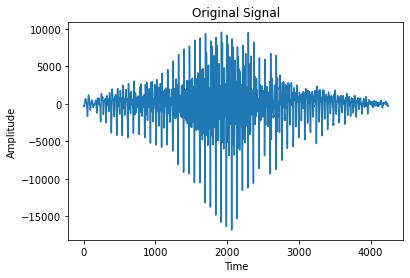

In [72]:
plt.plot(raw_temp) #'1_jackson_1.wav'
#structure
plt.title("Original Signal")
plt.ylabel('Amplitude')
plt.xlabel('Time')

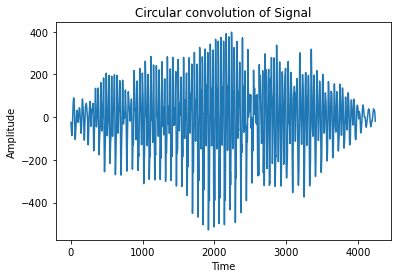

In [73]:
circ_final = convlve_CircularLinA(raw_temp,movingAverageFilter(100))

In [74]:
signal = raw_temp #_0_jackson_1.wave
filter_temp = movingAverageFilter(100)
L = signal.shape[0]
zeros = np.zeros((1,(L - filter_temp.size)))
filter_padd = np.append(filter_temp,zeros)

BF = blockMatrix_Dn(filter_padd)
dih_convolve_final = np.dot(BF, signal)

Text(0.5, 0, 'Time')

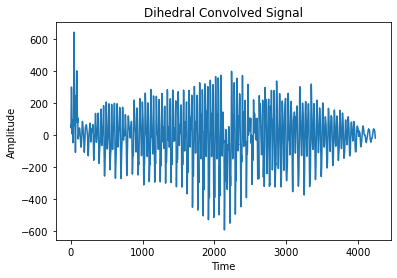

In [76]:
plt.plot(dih_convolve_final)
#structure
plt.title("Dihedral Convolved Signal")
plt.ylabel('Amplitude')
plt.xlabel('Time')

In [77]:
#difference between the Circular and Dihedral
diff = dih_convolve_final - circ_final

Text(0.5, 0, 'Time')

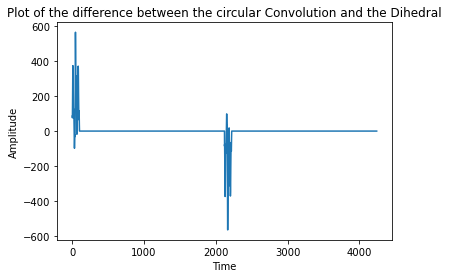

In [78]:
plt.plot(diff)
#structure
plt.title("Plot of the difference between the circular Convolution and the Dihedral")
plt.ylabel('Amplitude')
plt.xlabel('Time')

In [86]:
halfway = int(diff.shape[0]/2)

In [87]:
halfway

2121

Fourier Transform

Text(0.5, 0, 'Time')

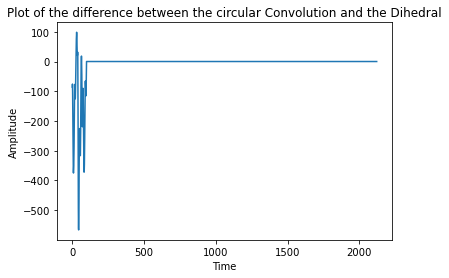

In [88]:
plt.plot(diff[halfway:])
#structure
plt.title("Plot of the difference between the circular Convolution and the Dihedral")
plt.ylabel('Amplitude')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

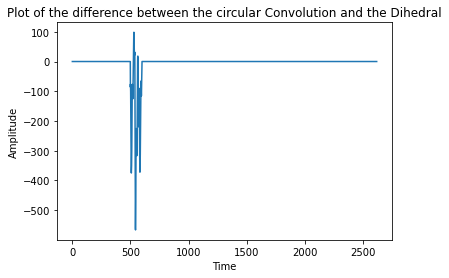

In [89]:
plt.plot(diff[(halfway-500):])
#structure
plt.title("Plot of the difference between the circular Convolution and the Dihedral")
plt.ylabel('Amplitude')
plt.xlabel('Time')

C:\Users\ericn\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Fourier transfom of orignal signal')

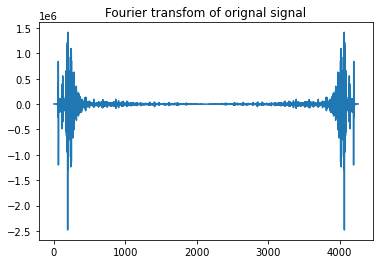

In [34]:
#original:
orig_fft = fft(signal)
plt.plot(orig_fft)
plt.title("Fourier transfom of orignal signal")

C:\Users\ericn\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Fourier transfom of circulant')

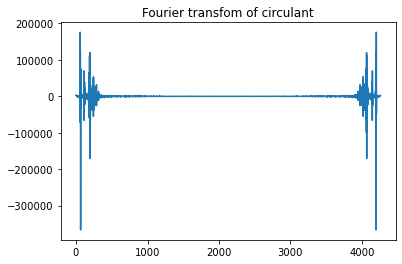

In [35]:
circ_fft = fft(circ_final)
plt.plot(circ_fft)
plt.title("Fourier transfom of circulant")

C:\Users\ericn\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Fourier transfom of Dihedral')

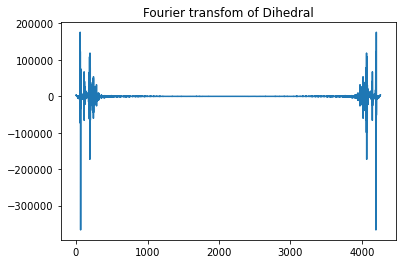

In [36]:
dih_fft = fft(dih_convolve_final)
plt.plot(dih_fft)
plt.title("Fourier transfom of Dihedral")

C:\Users\ericn\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Fourier transfom of differences')

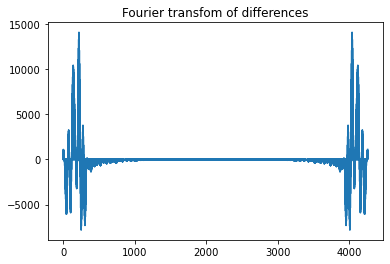

In [37]:
diff_fft = fft(diff)
plt.plot(diff_fft)
plt.title("Fourier transfom of differences")

#Examine the block matrix:
BF

In [50]:
print(BF[0])

[0.01 0.   0.   ... 0.   0.   0.  ]


In [49]:
BF.shape

(4260, 4260)

#### Fourier transformation

The fourier transform dialonalises the circulant matrix. Examine how this diagonalises the Reverse circulant and Block matrix

$w_{n} =\exp([2*\pi *i]/n)$

DFT:

$x^{k} = \begin{pmatrix}
w_{n}^{0*k} \\
w_{n}^{1*k}\\
\vdots \\
w_{n}^{(n-1)*k}
\end{pmatrix}$

$F = (x^{0} \ x^{1} \cdots \ x^{n-1})$

In [38]:
from scipy.linalg import dft
import cmath

In [39]:
np.set_printoptions(precision=2, suppress=True)

In [40]:
w(1,1,1)

NameError: name 'w' is not defined

#### Scipy DFT matrix

In [90]:
def Dihedral_block (filter_1):
    #creating arrays of Alpha and betas
    L = filter_1.size
    bound = int(L/2) #takes integer part 5.9 -> 5
    #print(bound)
    alpha_1 = filter_1[ :bound]
    beta_1 = filter_1[bound: ]
    
    # the Circulant and reverse circulant comes from the filter.
    A = spy.linalg.circulant(alpha_1)
    B = reverseCirc(beta_1)
    #print(A.shape)
    #print("---")
    #print(B.shape)
    #Creating a block matrix of A & B per dihedral RG matrix form
    block = np.block([[A,B],[B,A]])
    return block, A, B


In [98]:
# General filter to capture the reverse and cirular matricies
block, A1, B1 = Dihedral_block(np.array([1,2,3,4,5,6,7,8,9,10]))

In [99]:
block

array([[ 1,  5,  4,  3,  2,  6,  7,  8,  9, 10],
       [ 2,  1,  5,  4,  3,  7,  8,  9, 10,  6],
       [ 3,  2,  1,  5,  4,  8,  9, 10,  6,  7],
       [ 4,  3,  2,  1,  5,  9, 10,  6,  7,  8],
       [ 5,  4,  3,  2,  1, 10,  6,  7,  8,  9],
       [ 6,  7,  8,  9, 10,  1,  5,  4,  3,  2],
       [ 7,  8,  9, 10,  6,  2,  1,  5,  4,  3],
       [ 8,  9, 10,  6,  7,  3,  2,  1,  5,  4],
       [ 9, 10,  6,  7,  8,  4,  3,  2,  1,  5],
       [10,  6,  7,  8,  9,  5,  4,  3,  2,  1]])

In [100]:
n = block.shape[0]    #nxn matirx
m_ab = dft(n/2)       #Discrete fourier matrix for the smaller matricies A, B
minv = np.linalg.inv(m_ab)  #discrete fourier matrix inverse

In [108]:
print("A: Circulant Diagonalised")
first = np.dot(minv,A1)     #DFT inverse * circulant matrix
A1_final= np.dot(first,m_ab) 
print(A1_final.real)

A: Circulant Diagonalised
[[15.  -0.  -0.   0.   0. ]
 [-0.  -2.5 -0.  -0.  -0. ]
 [-0.  -0.  -2.5  0.  -0. ]
 [ 0.   0.   0.  -2.5 -0. ]
 [ 0.  -0.  -0.   0.  -2.5]]


In [107]:
print("Reverse Circ Diagonalisation without Permutation")
first = np.dot(minv,B1)    #DFT inv
B1_final= np.dot(first,m_ab)
print(B1_final.real)

Reverse Circ Diagonalisation without Permutation
[[40.  -0.  -0.   0.   0. ]
 [-0.  -0.  -0.  -0.  -2.5]
 [-0.  -0.  -0.  -2.5  0. ]
 [ 0.  -0.  -2.5  0.   0. ]
 [ 0.  -2.5  0.   0.   0. ]]


In [104]:
print("original reverse circ")
print(B1)   
print("1st flip (circulant)")
print(np.flip(B1,axis=0))
print("2nd flip")
print(np.flip(np.flip(B1,axis=0),axis=0))

original reverse circ
[[ 6  7  8  9 10]
 [ 7  8  9 10  6]
 [ 8  9 10  6  7]
 [ 9 10  6  7  8]
 [10  6  7  8  9]]
1st flip (circulant)
[[10  6  7  8  9]
 [ 9 10  6  7  8]
 [ 8  9 10  6  7]
 [ 7  8  9 10  6]
 [ 6  7  8  9 10]]
2nd flip
[[ 6  7  8  9 10]
 [ 7  8  9 10  6]
 [ 8  9 10  6  7]
 [ 9 10  6  7  8]
 [10  6  7  8  9]]


Two flips returns to the original

In [109]:
# flipping the dft matrix
B1_flip= np.flip(B1,axis=0)

first = np.dot(minv,B1_flip)    #DFT inverse * circulant form of reverse circulant
B1_final_flip = np.dot(first,m_ab)
print("Reverse Circ Diagonalisation with Permutation")
print(B1_final_flip.real)

Reverse Circ Diagonalisation with Permutation
[[40.  -0.  -0.   0.   0. ]
 [-0.   2.5  0.   0.   0. ]
 [-0.   0.   2.5 -0.   0. ]
 [ 0.  -0.   0.   2.5 -0. ]
 [ 0.   0.  -0.  -0.   2.5]]


In [110]:
#block
m = dft(n)
minv = np.linalg.inv(m)
first = np.dot(minv,block)
block_final= np.dot(first,m)

In [112]:
print("DFT diagonalisation applied to the block matrix")
print(block_final.real)

DFT diagonalisation applied to the block matrix
[[ 55.    -0.    -0.    -0.    -0.    -0.     0.     0.     0.     0.  ]
 [ -0.   -10.88  -0.    -2.93  -0.    -0.8   -0.     1.54   0.     8.07]
 [ -0.    -0.    -2.5   -0.     0.    -0.    -0.    -0.    -2.5   -0.  ]
 [  0.    -1.14  -0.    -3.72  -0.    -0.8   -0.    -2.67   0.     3.33]
 [ -0.     0.     0.    -0.    -2.5   -0.    -2.5   -0.     0.    -0.  ]
 [  0.     1.09  -0.    -0.69  -0.    -5.8    0.    -0.69  -0.     1.09]
 [ -0.    -0.     0.    -0.    -2.5    0.    -2.5   -0.     0.    -0.  ]
 [  0.     3.33  -0.    -2.67   0.    -0.8   -0.    -3.72   0.    -1.14]
 [  0.     0.    -2.5    0.     0.     0.     0.     0.    -2.5   -0.  ]
 [  0.     8.07   0.     1.54   0.    -0.8   -0.    -2.93  -0.   -10.88]]


In [113]:
from numpy import linalg as LA

In [115]:
evalue, evectors = LA.eig(block)

In [119]:
print(evalue.real)

[ 55. -25.  -5.  -5.   0.   0.  -0.  -0.  -5.  -5.]


In [121]:
print(evectors.real)

[[ 0.32  0.32  0.03  0.03  0.02  0.02  0.16  0.16  0.02 -0.29]
 [ 0.32  0.32 -0.51 -0.51 -0.08 -0.08  0.13  0.13  0.11  0.49]
 [ 0.32  0.32 -0.1  -0.1  -0.1  -0.1   0.19  0.19  0.32  0.26]
 [ 0.32  0.32  0.28  0.28 -0.37 -0.37 -0.52 -0.52 -0.6  -0.15]
 [ 0.32  0.32  0.29  0.29  0.54  0.54  0.05  0.05  0.15 -0.3 ]
 [ 0.32 -0.32 -0.29 -0.29 -0.02 -0.02 -0.16 -0.16 -0.15  0.3 ]
 [ 0.32 -0.32 -0.28 -0.28 -0.54 -0.54 -0.05 -0.05  0.6   0.15]
 [ 0.32 -0.32  0.1   0.1   0.37  0.37  0.52  0.52 -0.32 -0.26]
 [ 0.32 -0.32  0.51  0.51  0.1   0.1  -0.19 -0.19 -0.11 -0.49]
 [ 0.32 -0.32 -0.03 -0.03  0.08  0.08 -0.13 -0.13 -0.02  0.29]]


In [123]:
#block
minv = np.linalg.inv(evectors)
first = np.dot(minv,block)
block_final2= np.dot(first,evectors)
print(block_final2.real)

[[ 55.   0.  -0.  -0.   0.   0.   0.   0.  -0.  -0.]
 [ -0. -25.  -0.  -0.  -0.  -0.   0.   0.  -0.   0.]
 [ -0.  -0.  -5.   0.   0.  -0.   0.  -0.  -0.  -0.]
 [  0.  -0.  -0.  -5.  -0.  -0.  -0.   0.  -0.   0.]
 [  0.  -0.   0.   0.  -0.   0.   0.  -0.  -0.   0.]
 [  0.   0.  -0.  -0.   0.  -0.   0.  -0.   0.   0.]
 [  0.  -0.   0.   0.   0.   0.   0.   0.   0.  -0.]
 [  0.  -0.   0.   0.  -0.  -0.  -0.   0.   0.  -0.]
 [ -0.   0.   0.   0.  -0.  -0.   0.   0.  -5.  -0.]
 [  0.  -0.   0.   0.  -0.  -0.   0.   0.  -0.  -5.]]


In [ ]:
#leverage the fourier matrix:
def w(n,j,k):
    p = 2*np.pi/n
    z=complex(0,p)
    f = np.exp(z*(j*k))
    return f

In [ ]:
w1 = w(3,1,1)
w1

In [ ]:
-w1*w1

In [ ]:
dia = np.array([[4,0,0,0,0,0],[0,-w1*w1, 2*(w1*w1), 0, 0,0],[0,2*w1,-w1,0,0,0],[0,0,0,0,0,0],[0,0,0,0,-w1*w1,-2*w1*w1],[0,0,0,0,-2*w1,-w1]])

In [ ]:
dia_inv= np.linalg.pinv(dia) 

In [ ]:
dia_inv

In [ ]:
first = np.dot(dia_inv,block)    #DFT inv
test= np.dot(first,dia)
print(test.real)

### SVM

In [ ]:
os.chdir('C:\\Users\\ericn\\Documents\\University\\2021\\Quantitative Project\\Numbers audio dataset\\recordings')
fileNames = os.listdir()
#listdir will list everything within the directory (aka folder).

#### Model Building
Attempt to build and train a support vector classifier

In [ ]:
# SVM related
from sklearn.svm import LinearSVC

In [ ]:
#Importing the wav files
Stor=np.zeros((2,2000))

for i in range(1353):
    if(i%150 == 0 or i%150 == 1 or i%150 == 2):
        file1 = wave.open(fileNames[i], mode="r")
        raw1 = file1.readframes(-1)
        raw_temp = np.frombuffer(raw1,"int16")
        #print(raw_temp.shape)
        rawArray1 =raw_temp[500:2500]
        Stor = np.append(Stor,[rawArray1],axis=0)
Stor = Stor[2:]

In [ ]:
# 50 files per person (3) for 10 digits. Taking three examples to build the model
y=np.array([])
for i in range(1353):
    if(i%150 == 0 or i%150 == 1 or i%150 == 2):
        #print(fileNames[i][0])
        y = np.append(y, int(fileNames[i][0]))
y

In [ ]:
dih_stor = np.zeros((2,2000))

filter_temp = movingAverageFilter(50)
L = Stor.shape[1]
zeros = np.zeros((1,(L - filter_temp.size)))
filter_padd = np.append(filter_temp,zeros)

for i in range(Stor.shape[0]):
    signal_part1 = Stor[i]
    BF = blockMatrix_Dn(filter_padd)
    dih_convolve_temp = np.dot(BF, signal_part1)
    dih_stor = np.append(dih_stor,[dih_convolve_temp],axis=0)

dih_stor = dih_stor[2:]

In [ ]:
#datasets
X=dih_stor
y=y

#initialise
svm_m1 = LinearSVC(max_iter = 1e4)
#fitting
svm_m1.fit(X,y)
y_hat = svm_m1.predict(X)

In [ ]:
#Error
np.sum(y_hat-y)

In [ ]:
#Without Convolve
X=Stor
y=y

#initialise
svm_m2 = LinearSVC(max_iter = 1e4)
#fitting
svm_m2.fit(X,y)
y_hat2 = svm_m1.predict(X)

In [ ]:
#Error
np.sum(y_hat2-y)